In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <AA076682-B999-31A8-AEA6-2BF697B54762> /opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EFA5DD93-D595-31E3-8640-3366FBC953DC> /opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor):
    tensor = tensor.permute(1, 2, 0)

    # Step 2: Convert the tensor to a NumPy array
    array = tensor.cpu().numpy()

    # Step 3: Scale the pixel values to the range [0, 1]
    array = (array - np.min(array)) / (np.max(array) - np.min(array))

    # Step 4: Clip the pixel values to the valid range [0, 1]
    array = np.clip(array, 0, 1)

    # Step 5: Display the RGB image using matplotlib
    plt.imshow(array)
    plt.axis('off')
    plt.show()

def imshow_grayscale(img):
    img = (img + 1) * 0.5
    # clipped_output = np.clip(img, 0, 1)
    plt.imshow(img, cmap='gray')
    plt.show()

In [3]:
# hyperparameters
batch_size = 128 
n_channels = 3
num_timesteps = 1000
img_dim = 32

device = "mps"

In [4]:

# transformMNIST = transforms.Compose([
#     transforms.Pad(padding=2, fill=0, padding_mode='constant'), 
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: (x - 0.5) * 2.0)
# ])

transformCIFAR = transforms.Compose([
    transforms.ToTensor(),
   transforms.Normalize([0.5], [0.5]),

])

# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transformMNIST)
# trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformCIFAR)
train_airplanes = [(img, label) for img, label in cifar_train if label == 7]
# only pick airplanes
trainloader = torch.utils.data.DataLoader(train_airplanes, batch_size=batch_size, shuffle=True)

# # sample from the dataloader
for batch in (trainloader):
    # imshow(batch[0][0])
    break

# # sample from the dataloader



Files already downloaded and verified


In [5]:

beta_schedule = torch.linspace(1e-4, 0.02, num_timesteps)
alpha_schedule = 1. - beta_schedule

def get_alphas(num_timesteps):
    alphas = [alpha_schedule[t] for t in range(num_timesteps)]
    return torch.cumprod(torch.tensor(alphas), 0).to(device)

# alphas_cumprod = get_alphas(num_timesteps)
alphas_cumprod = torch.tensor([torch.prod(alpha_schedule[:i + 1]) for i in range(len(alpha_schedule))]).to(device)

# returns tuple (noised image, noise)
def get_noised_image_at(t, image):
    alpha = alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device)
    noise = torch.randn(batch_size, n_channels, img_dim, img_dim, device=device)
    noise_factor = torch.sqrt(1 - alpha)
    return ((torch.sqrt(alpha) * image) + (noise * noise_factor), noise)


In [6]:
def get_sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    return embedding

In [7]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, dim):
#         super(MultiHeadAttention, self).__init__()
#         self.dim = dim
#         self.num_heads = 2
#         self.hidden_dim = 16
#         self.qkv = nn.Linear(dim, self.hidden_dim * 3, bias=False) 
#         self.map = nn.Linear(self.hidden_dim, dim)

#     def forward(self, x):
#         # apply along channel dim (1)
#         shaped_x = x.permute(0, 2, 3, 1) # (B, H, W, C)
#         q,k,v = self.qkv(shaped_x).chunk(3, dim=-1) # (B, H, W, 3 * hidden_dim)
        
#         q = q.reshape(x.shape[0] * self.num_heads, x.shape[-1] * x.shape[-2], self.hidden_dim // (self.num_heads))
#         k = k.reshape(x.shape[0] * self.num_heads, self.hidden_dim // (self.num_heads), x.shape[-1] * x.shape[-2])
#         v = v.reshape(x.shape[0] * self.num_heads, x.shape[-1] * x.shape[-2], self.hidden_dim // (self.num_heads)) 

#         out = (1/np.sqrt(self.hidden_dim)) * (q @ k) # (B*Hds, H*W, H*W) -> each pixel "sees" the other
#         out = F.softmax(out, dim=-1) @ v # (B*Hds, H*W, dv)

#         # target shape = (B, H, W, C)
#         out = out.view(x.shape[0], x.shape[-2], x.shape[-1], self.hidden_dim)
#         out = self.map(out)
#         out = out.permute(0, 3, 1, 2)
#         # residual connection
#         out += x

#         return out

# copy linear attention for now from HuggingFace
from einops import rearrange

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=28):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out) + x


In [8]:
class WideResidualBlock(nn.Module):
    def __init__(self, channels_in, channels_out, im_dim):
        super(WideResidualBlock, self).__init__()
        # two convolutional layers and a skip connection for residual
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1).to(device) 
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1).to(device)
        self.ln1 = nn.LayerNorm([channels_in, im_dim, im_dim]).to(device)
        # self.ln2 = nn.LayerNorm([channels_out, im_dim, im_dim]).to(device)
        self.skip_connection = nn.Conv2d(channels_in, channels_out, 1).to(device)

    def forward(self, x, norm=True):
        out = self.ln1(x) if norm else x
        out = F.silu((self.conv1(out)))
        out = F.silu((self.conv2(out)))
        out = out + self.skip_connection(x)
        return out
        
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, im_dim):
        super(DownsampleBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # two residual blocks and a downsampling operation
        self.attention = LinearAttention(out_channels).to(device)
        self.wide_residual_block1 = WideResidualBlock(self.in_channels, self.out_channels, im_dim).to(device)
        self.wide_residual_block2 = WideResidualBlock(self.out_channels, self.out_channels, im_dim).to(device)
        self.wide_residual_block3 = WideResidualBlock(self.out_channels, self.out_channels, im_dim).to(device)
        self.max_pool = nn.MaxPool2d(2, 2).to(device)

    def forward(self, x, t):
        x = x + t.reshape(x.shape[0], -1, 1, 1)
        x = self.wide_residual_block1(x)
        x = self.attention(x)
        x = self.wide_residual_block2(x)
        x = self.wide_residual_block3(x)
        x = self.max_pool(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, im_dim, concat=True):
        super(UpsampleBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.concat = concat
        self.attention = LinearAttention(out_channels).to(device)
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1).to(device)
        self.upsample_channels = nn.Conv2d(in_channels, out_channels, 1).to(device) 
        self.cat_map = nn.Conv2d(out_channels*2, out_channels, 1).to(device) if concat else None
        self.wide_residual_block1 = WideResidualBlock(self.out_channels, self.out_channels, im_dim).to(device)
        self.wide_residual_block2 = WideResidualBlock(self.out_channels, self.out_channels, im_dim).to(device)
        self.wide_residual_block3 = WideResidualBlock(self.out_channels, self.out_channels, im_dim).to(device)

    def forward(self, x, skip_conn, time_embed, norm=True):
        x = F.silu(self.upsample_channels(self.upsample(x)))
        # skip connection
        x = torch.cat((x, skip_conn), dim=1) if self.concat else x
        x = F.silu(self.cat_map(x)) if self.concat else x
        x = x + time_embed.reshape(x.shape[0], -1, 1, 1)
        x = self.wide_residual_block1(x)
        x = self.attention(x) 
        x = self.wide_residual_block2(x)
        x = self.wide_residual_block3(x, norm)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.time_emb_dim = 100
        self.max_dim = 280

        self.time_embed = nn.Embedding(num_timesteps, self.time_emb_dim)
        self.time_embed.weight.data = get_sinusoidal_embedding(num_timesteps, self.time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.time_embed_mlps = nn.ModuleList([nn.Sequential(
            nn.Linear(self.time_emb_dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        ) for dim in [n_channels,32,90, 160]])
    

        self.downsamplers = nn.ModuleList([DownsampleBlock(n_channels, 32, img_dim), DownsampleBlock(32, 90, 16), DownsampleBlock(90, 160, 8), DownsampleBlock(160, self.max_dim, 4)])
        self.upsamplers = nn.ModuleList([UpsampleBlock(self.max_dim, 160, 4), UpsampleBlock(160, 90, 8), UpsampleBlock(90, 32, 16), UpsampleBlock(32, 32, 32, concat=False)])
        

        self.latent_resnet1 = WideResidualBlock(self.max_dim, self.max_dim, 2).to(device)
        self.latent_resnet2 = WideResidualBlock(self.max_dim, self.max_dim, 2).to(device)
        self.final_conv = nn.Sequential(
            nn.Conv2d(32 , n_channels , 3, padding=1).to(device),
            )

    def forward(self, x, t):
        t = self.time_embed(t)
        time_embeds = [self.time_embed_mlps[i](t) for i in range(len(self.downsamplers))]
        residuals = []
        for i in range(len(self.downsamplers)):
            residuals.append(x)
            x = self.downsamplers[i](x, time_embeds[i])

        x = self.latent_resnet2((self.latent_resnet1(x)))
        # x = self.latent_resnet2((self.latent_resnet1(x)))

        for i in range(len(self.upsamplers)):
            normalise_ = False if i == len(self.upsamplers) - 1 else True
            t_embed = time_embeds[-(i+1)] if i < len(self.upsamplers) - 1 else time_embeds[1]
            x = self.upsamplers[i](x, residuals.pop(),t_embed, normalise_)
            

        return self.final_conv(x)

    

In [27]:
# unet = UNet()
# unet.to(device)
# PATH = "horse_bigmodel_cifar.pth"

# checkpoint = torch.load(PATH)
# unet.load_state_dict(checkpoint['model_state_dict'])

unet.train()

print(sum([p.numel() for p in unet.parameters() if p.requires_grad]))

num_epochs = 80
# l1 loss
loss_fn = F.huber_loss
optimizer = torch.optim.Adam(unet.parameters(), lr=2e-3)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for i in range(num_epochs):
    for j, (batch, _) in tqdm(enumerate(trainloader)):
        optimizer.zero_grad()
        images = batch.to(device)

        if(images.shape[0] != batch_size):
            continue
        # adding noise
        time_vals = torch.randint(1, num_timesteps+1, (batch_size,), device=device)
        batch_, noise = get_noised_image_at(time_vals - 1, images)
        # forward pass, get predicted noise
        predicted_noise = unet(batch_, time_vals)
        loss_val = loss_fn(predicted_noise, noise)
        # if j % 100 == 0:
        #     print(loss_val.item())
        loss_val.backward()
        optimizer.step()
    print(f"Epoch {i+1}, Loss: {loss_val.item()}")

15104254


40it [00:15,  2.51it/s]


Epoch 1, Loss: 0.01707809418439865


40it [00:15,  2.55it/s]


Epoch 2, Loss: 0.017841041088104248


40it [00:16,  2.49it/s]


Epoch 3, Loss: 0.026278113946318626


40it [00:15,  2.52it/s]


Epoch 4, Loss: 0.018808964639902115


40it [00:15,  2.51it/s]


Epoch 5, Loss: 0.021480977535247803


40it [00:15,  2.52it/s]


Epoch 6, Loss: 0.018902620300650597


40it [00:15,  2.51it/s]


Epoch 7, Loss: 0.015675636008381844


40it [00:15,  2.53it/s]


Epoch 8, Loss: 0.015959182754158974


40it [00:15,  2.50it/s]


Epoch 9, Loss: 0.021553626284003258


40it [00:15,  2.50it/s]


Epoch 10, Loss: 0.017305690795183182


10it [00:04,  2.44it/s]

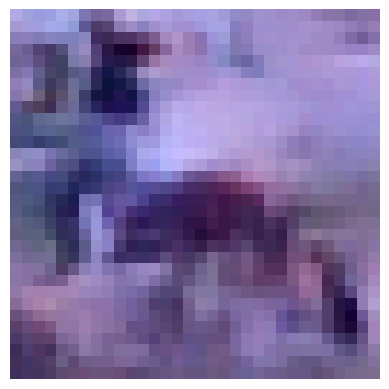

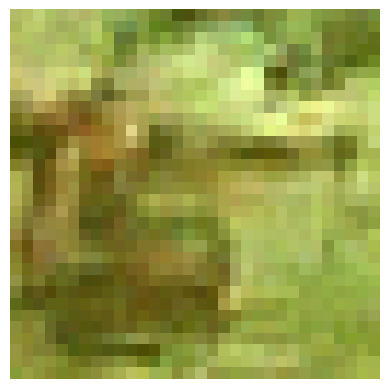

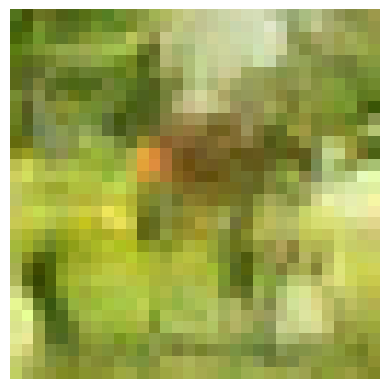

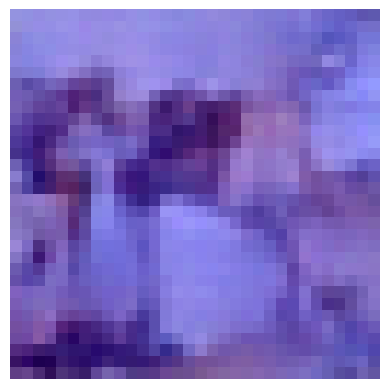

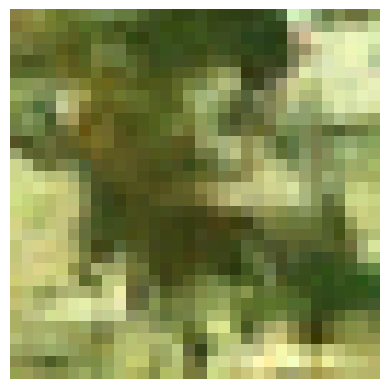

In [26]:
# diffusion model sampling code:
# unet = UNet()
# unet.to(device)
# unet.load_state_dict(torch.load("horse2.pth"))


import einops

with torch.no_grad():
    unet.eval()

    # sample from the model
    # time_vals = torch.randint(1, num_timesteps+1, (batch_size,), device=device)
    test_batch_size = 5
    x = torch.randn(test_batch_size, n_channels, img_dim, img_dim, device=device)
    # print(x.shape)

    for t in range(num_timesteps, 0, -1):
        time_tensor = (torch.ones(1, 1) * t).to(device).long()
        # repeat the time tensor along the batch dimension
        time_tensor = time_tensor.repeat(test_batch_size, 1)
    
        
        eta_theta = unet(x, time_tensor)
        alpha_t = alpha_schedule[t-1]
        alpha_t_bar = alphas_cumprod[t-1]

        x = (1 / alpha_t.sqrt()) * (x - ((1 - alpha_t) / (1 - alpha_t_bar).sqrt()) * eta_theta)
        
        z = torch.randn(test_batch_size, n_channels, img_dim, img_dim).to(device)

        beta_t = beta_schedule[t-1]
        sigma_t = beta_t.sqrt()

        x = x + (sigma_t * z)

        if( t == 1):
            for i in range(test_batch_size):
                imshow(x[i])
            # imshow(x[0])


    

In [22]:
# # checkpoint model
# torch.save({
#             'model_state_dict': unet.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, "horse_bigmodel_cifar.pth")
